<a href="https://colab.research.google.com/github/InvoLab101/10conv-poc/blob/main/10conversation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Install dependencies

In [25]:
!pip install openai
!pip install diskcache

##### load data, load function

In [2]:
from google.colab import drive
import sys
import os
import pandas as pd
import json
import openai
import logging
import diskcache
import matplotlib.pyplot as plt

drive.mount('/content/drive', force_remount=True)
conversation_folder = '/content/drive/MyDrive/work_asu/10conversations'  # Change this to your desired directory
conversation_files = os.listdir(conversation_folder)
QUESTIONS = [
    'Did the HDA welcome the customer to the bank, introduce himself/herself by name, and attained customer\'s name immediately? (Yes or No)',
    'Did the HDA acknowledge the customer’s request, paraphrased back to demonstrate active listening and understanding of the customer\'s request or needs? (Yes or No)',
    'Did the HDA demonstrate empathy of customer\'s concern (Yes or No)',
    'Did the HDA make strong/confident customer advocacy statements? (Yes or No)',
    'Did the HDA promote passcode for future interactions? (Yes or No or NA)',
    'Did the HDA gain permissions to ask questions and make value added recommendations? (Yes or No)',
    'Did the HDA solve the customer’s request efficiently and position alternatives with customer benefits and educate customer as needed? (Yes or No)',
    'Was a call transfer absolutely necessary to resolve the customer’s request? (Yes or No or NA)',
    'Did the HDA add value by promoting or offering or acknowledging digital banking use and services? (Yes or No)',
    'Did the HDA use benefit statements to explain why the product or service is of value to the customer’s needs and ask for the business? (Yes or No)',
    'Did the HDA accurately recap the conversation, provide a clear explanation of next steps setting expectations, and check for additional needs? (Yes or No)',
    'Did the HDA thank the customer by name for their loyalty to the bank and close with appreciation for their business? (Yes or No)'
    ]

QAFORM_QUESTIONS = [
    "Welcome the customer to BMO, introduced yourself by name, and attained customer's name immediately",
    "Acknowledged the customer’s request, paraphrased back- demonstrating active listening and understanding of the customer’s request/needs",
    "Demonstrated empathy of customer's concern (APAC)",
    "Made strong/confident customer advocacy statement(s)",
    "Promoted passcode for future interactions",
    "Gained permissions to ask questions and make value-added recommendations",
    "Solved the customer’s request efficiently- positioning alternatives with customer benefits and educated the customer as needed",
    "Was a call transfer absolutely necessary to resolve the customer’s request?",
    "Added value by promoting/offering/acknowledging digital banking use and services",
    "Used benefit statements to explain why the product/service is of value to the customer’s needs and asked for the business",
    "Accurately recapped the conversation, provided a clear explanation of next steps setting expectations, and checked for additional needs",
    "Thanked the customer by name for their loyalty to BMO since ____ and closed with appreciation for their business"
]

conversations = []
for filename in conversation_files:
    with open(os.path.join(conversation_folder, filename), "r") as file:
        conversation = file.read()
        conversations.append(conversation)

data = pd.DataFrame({"Conversation": conversations})

print(f"loaded {len(data['Conversation'])} conversations")
print(f"loaded {len(QUESTIONS)} questions")


with open("/content/drive/MyDrive/work_asu/human_answers.json", "r") as human_answers_file:
    human_answers = json.load(human_answers_file)
data["human_answers"] = ""
for conversation, answers in human_answers.items():
    mask = data["Conversation"] == conversation
    data.loc[mask, "human_answers"] = json.dumps(answers)
print('loaded human answers')



with open("/content/drive/MyDrive/work_asu/config.json", "r") as config_file:
    config = json.load(config_file)
openai.api_key = config["openai_api_key"]
print('openAi key loaded')






cache = diskcache.Cache("/content/drive/MyDrive/work_asu")
print("cache loaded")

def promtAskAllQuestionForOneConversation(conversation):
    prompt = '''
below is a customer service call between a Help Desk Agent(HDA) and Customer(C).


{}


based on the conversation above, answer all these questions:

{}

Only give me the answers in order and put them in a list


    '''.format(conversation.strip(), '\n'.join(QUESTIONS))
    logging.debug("engineered prompt: {}".format(prompt))
    return prompt


def get_openai_answer(conversation, modelName):
    # print(promtAskAllQuestionForOneConversation(conversation))
    response = openai.Completion.create(
      # model="text-davinci-003",
      model = modelName,
      prompt=promtAskAllQuestionForOneConversation(conversation),
      temperature=0,
      max_tokens=70,
      top_p=1,
      frequency_penalty=0,
      presence_penalty=0,
    )
    logging.info(response)
    return response.choices[0].text

def get_openai_answer_with_disk_cache(conversation, modelName):
    cache_key = (conversation, modelName)
    answers = []
    # Check if the answer is in the cache
    if cache_key in cache:
        print('in cache')
        answers = cache[cache_key]
    else:
      print('not in cache, need to call openai')
      # If not in cache, fetch the answer and store it in the cache
      ai_answers = get_openai_answer(conversation, modelName)  # Implement your OpenAI API call here
      answers = ai_answers.strip('\n').strip('.').replace(" ", "").lower().split(',')
      if (len(answers)!= len(QUESTIONS)):
            raise Exception(f"anwsers count invalid: {len(answers)}. {answers}")
      cache[cache_key] = answers
    print(answers)
    return answers


Mounted at /content/drive
loaded 10 conversations
loaded 12 questions
loaded human answers
openAi key loaded
cache loaded


##### answer questions using AI model

In [3]:
# cache.clear()
MODEL_NAME = "text-davinci-003"
data["OpenAI_Answers"] = data["Conversation"].apply(lambda conv: get_openai_answer_with_disk_cache(conv, MODEL_NAME))
print(data)

in cache
['yes', 'yes', 'yes', 'no', 'na', 'yes', 'yes', 'no', 'no', 'no', 'yes', 'no']
in cache
['yes', 'yes', 'yes', 'yes', 'na', 'yes', 'yes', 'na', 'yes', 'yes', 'yes', 'no']
in cache
['yes', 'yes', 'yes', 'yes', 'na', 'yes', 'yes', 'no', 'no', 'no', 'yes', 'no']
in cache
['yes', 'yes', 'yes', 'no', 'na', 'yes', 'yes', 'no', 'no', 'no', 'yes', 'no']
in cache
['yes', 'yes', 'yes', 'no', 'na', 'yes', 'yes', 'no', 'no', 'no', 'yes', 'no']
in cache
['yes', 'yes', 'yes', 'no', 'na', 'yes', 'no', 'no', 'no', 'no', 'yes', 'no']
in cache
['yes', 'yes', 'yes', 'no', 'na', 'yes', 'yes', 'na', 'no', 'no', 'yes', 'no']
in cache
['yes', 'yes', 'yes', 'no', 'na', 'yes', 'yes', 'no', 'no', 'no', 'yes', 'no']
in cache
['yes', 'yes', 'yes', 'no', 'na', 'yes', 'yes', 'na', 'no', 'no', 'yes', 'no']
in cache
['yes', 'yes', 'yes', 'yes', 'na', 'yes', 'yes', 'na', 'no', 'no', 'yes', 'no']
                                        Conversation  \
0  Help Desk Agent (HDA): Hello, thank you for ca...   
1  H

##### AI model performance

    0    1    2    3   4    5    6   7    8    9    10  11
0  yes  yes  yes   no  na  yes  yes  no   no   no  yes  no
1  yes  yes  yes  yes  na  yes  yes  na  yes  yes  yes  no
2  yes  yes  yes  yes  na  yes  yes  no   no   no  yes  no
3  yes  yes  yes   no  na  yes  yes  no   no   no  yes  no
4  yes  yes  yes   no  na  yes  yes  no   no   no  yes  no
5  yes  yes  yes   no  na  yes   no  no   no   no  yes  no
6  yes  yes  yes   no  na  yes  yes  na   no   no  yes  no
7  yes  yes  yes   no  na  yes  yes  no   no   no  yes  no
8  yes  yes  yes   no  na  yes  yes  na   no   no  yes  no
9  yes  yes  yes  yes  na  yes  yes  na   no   no  yes  no
   0   1    2    3   4   5    6    7    8    9    10  11
0  no  no  yes   no  na  no  yes   na   no   no   no  no
1  no  no  yes  yes  na  no  yes   no   no   no  yes  no
2  no  no  yes  yes  na  no  yes  yes  yes  yes  yes  no
3  no  no  yes   no  na  no  yes   na   no   no  yes  no
4  no  no  yes   no  na  no  yes   na   no   no  yes  no
5  no  no

<ipython-input-7-c2283663527c>:40: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


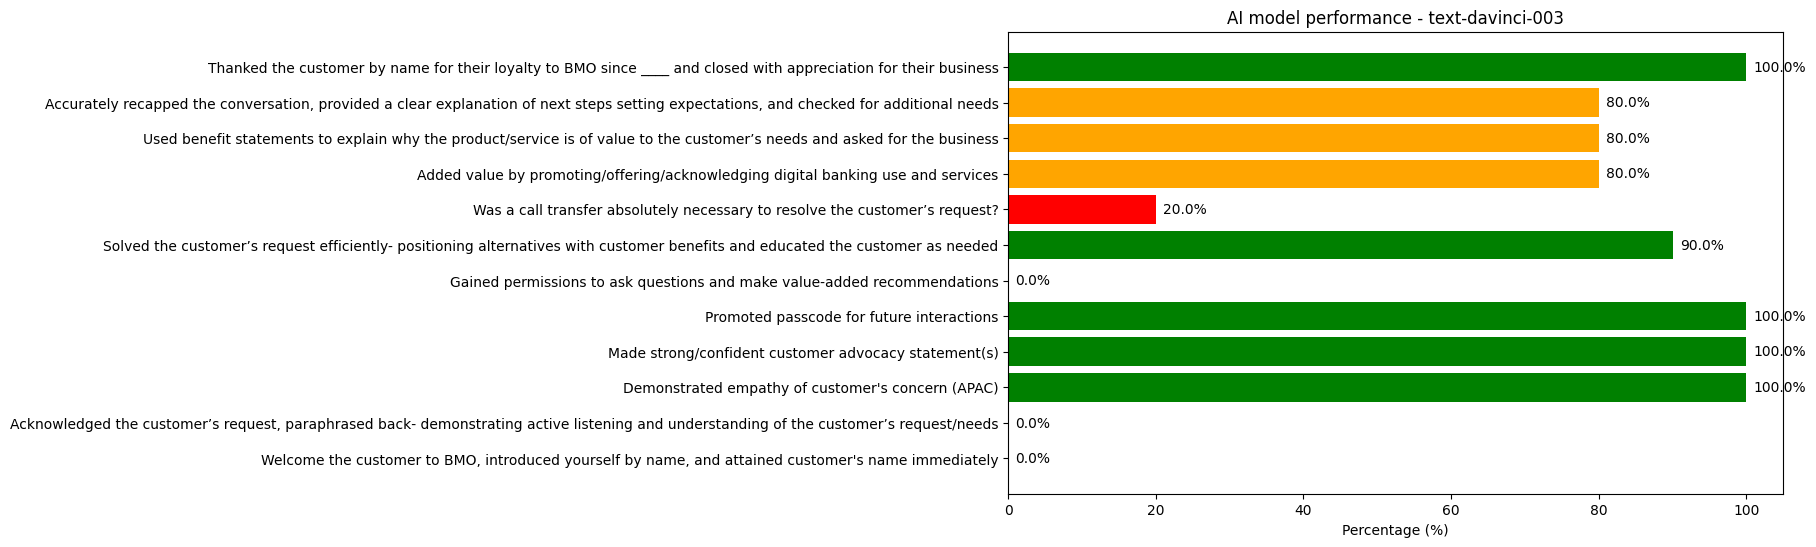

In [7]:
openai_df = pd.DataFrame(data['OpenAI_Answers'].tolist())
try:
    data["human_answers"] = data["human_answers"].apply(json.loads)
except Exception:
    pass
human_df = pd.DataFrame(data["human_answers"].tolist())
# human_df = pd.DataFrame(list(map(json.loads(str), data['human_answers'].tolist())))
print(openai_df)
print(human_df)


comparison_result = (openai_df == human_df).astype(int)
print(comparison_result)

percentage_ones = (comparison_result.mean() * 100).round(2)
print(percentage_ones)





# Define colors based on percentage thresholds
colors = ['red' if p < 40 else 'green' if p > 80 else 'orange' for p in percentage_ones]

# Create a horizontal bar plot with custom colors for the percentage of 1s for each column
plt.figure(figsize=(10, 6))
bars = plt.barh(range(len(percentage_ones)), percentage_ones, color=colors)
plt.title(f"AI model performance - {MODEL_NAME}")
# plt.ylabel('Columns')
plt.xlabel('Percentage (%)')

# Increment y-axis ticks by 1 and append "question" to each tick label
tick_labels = [f'{QAFORM_QUESTIONS[label]}' for label in percentage_ones.index]
plt.yticks(range(len(percentage_ones)), tick_labels, rotation=0)

# Add data labels next to the bars
for bar, percentage in zip(bars, percentage_ones):
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height() / 2, f'{percentage}%', va='center')

plt.tight_layout()
plt.show()


##### bias

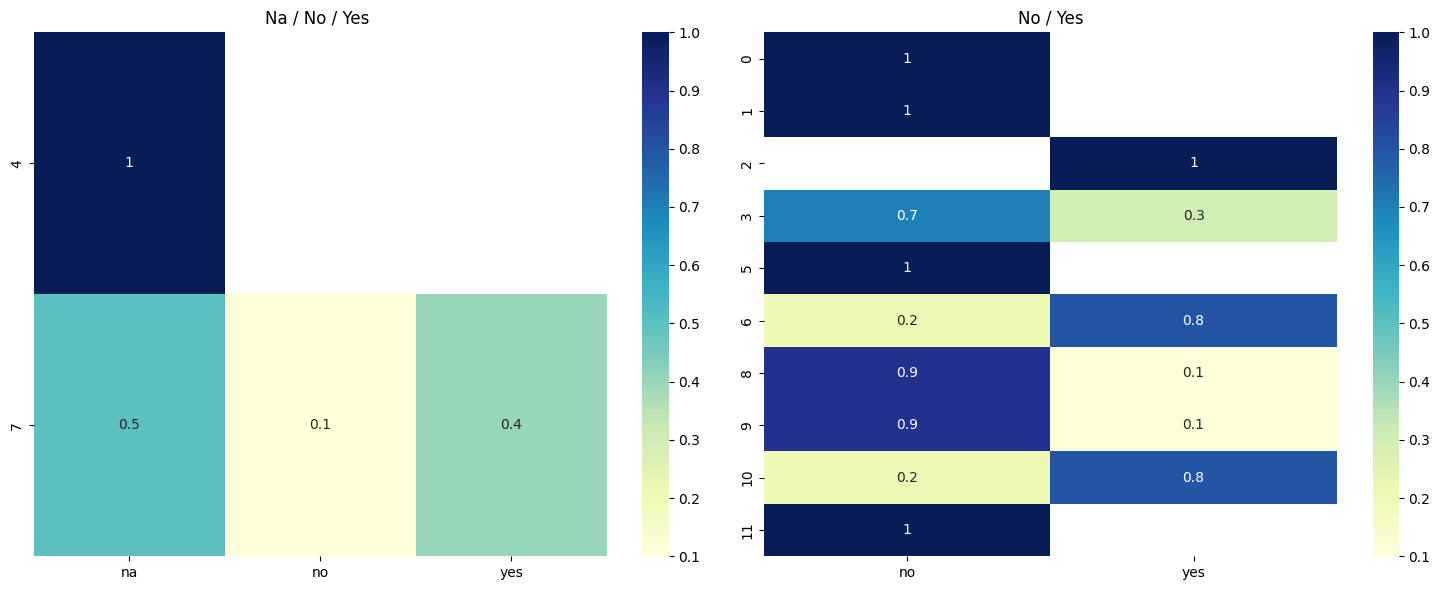

In [8]:
from sklearn.metrics import cohen_kappa_score
import seaborn as sns

# List of indices for columns with mixed responses ("yes", "no", "na")
mixed_response_indices = [4, 7]  # Replace with the actual indices

# List of indices for columns with binary responses ("yes", "no")
binary_response_indices = [0, 1, 2, 3, 5, 6, 8, 9, 10, 11]  # Replace with the actual indices

# Calculate Response Distribution for mixed-response questions
mixed_response_distribution = human_df.iloc[:, mixed_response_indices].apply(lambda x: x.value_counts(normalize=True)).T

# Calculate Response Distribution for binary-response questions
binary_response_distribution = human_df.iloc[:, binary_response_indices].apply(lambda x: x.value_counts(normalize=True)).T


# 4. Visualize the Bias
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.heatmap(mixed_response_distribution, annot=True, cmap="YlGnBu")
plt.title("Na / No / Yes ")

plt.subplot(1, 2, 2)
sns.heatmap(binary_response_distribution, annot=True, cmap="YlGnBu")
plt.title("No / Yes")

plt.tight_layout()
plt.show()




# # Visualize agreement scores
# plt.bar(agreement_scores.keys(), agreement_scores.values())
# plt.xticks(rotation=45, ha="right")
# plt.xlabel("Questions")
# plt.ylabel("Cohen's Kappa Score")
# plt.title("Inter-Rater Agreement for Each Question")
# plt.show()